# The model tries to predict whether the user will churn in the future 2 months (month-2 and month-3), given the feature generated from month-0 and month-1.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
import math

# # from scipy import stats
# from scipy.stats import chi2, chi2_contingency
# import statsmodels.stats.api as sms

# import ttd_experiment as ttd
%matplotlib inline

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.metrics import mean_squared_error, r2_score
# import itertools
# import random
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, roc_auc_score

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/wishpy/dataworker.py:83: UserWarning: [Errno 2] No such file or directory: '../../../wishpy/client_secret.json'
  warnings.warn(str(e))


In [2]:
df_raw = dw.td_query('''
select age
       ,gender
       ,waiting_day_1st_txn_bucket
       ,COAlESCE(user_first_txn_refund_category,'no refund') as user_first_txn_refund_category
       ,order_cnt
       ,min_shipping_time_shown_avg
       ,max_shipping_time_shown_avg
       ,mix_ttd_avg
       ,gmv
       ,gmv_avg
       ,user_ltv_segment
       ,previous_m_is_churned
       ,late_days_avg
       ,late_order_p
       ,refund_order_p
       ,lr_order_p
       ,we_order_p
       
       ,m_is_churned
from analytics.jay_churn_model_training_base
where country_code = 'US'
'''
,job_id=788586339
,engine='presto'
                )

You can look at job id 788586339


In [3]:
df = df_raw.copy()
df.head()

age  gender  waiting_day_1st_txn_bucket user_first_txn_refund_category  \
0  NaN       1                         0.0                      no refund   
1  NaN       2                         6.8                      no refund   
2  NaN       2                         0.0                      no refund   
3  NaN       2                         0.0                      no refund   
4  NaN       2                         0.0                      no refund   

   order_cnt  min_shipping_time_shown_avg  max_shipping_time_shown_avg  \
0          1                         17.0                         34.0   
1          1                         12.0                         29.0   
2          1                         13.0                         30.0   
3          1                         14.0                         29.0   
4          1                         20.0                         34.0   

   mix_ttd_avg   gmv  gmv_avg user_ltv_segment  previous_m_is_churned  \
0          NaN   1.0     1.00          ltv_low                      1   
1         15.0  40.0    40.00          ltv_med                      1   
2          NaN   1.0     1.00          ltv_low                      1   
3          NaN   1.0     1.00          ltv_low                      1   
4         18.0  13.0    12.99          ltv_med                      1   

   late_days_avg  late_order_p  refund_order_p  lr_order_p  we_order_p  \
0            0.0           0.0             0.0         0.0         0.0   
1            0.0           0.0             0.0         0.0         0.0   
2            0.0           0.0             0.0         0.0         0.0   
3            0.0           0.0             0.0         0.0         0.0   
4            0.0           0.0             0.0         0.0         0.0   

   m_is_churned  
0             1  
1             1  
2             1  
3             1  
4             1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644626 entries, 0 to 5644625
Data columns (total 18 columns):
age                               float64
gender                            int64
waiting_day_1st_txn_bucket        float64
user_first_txn_refund_category    object
order_cnt                         int64
min_shipping_time_shown_avg       float64
max_shipping_time_shown_avg       float64
mix_ttd_avg                       float64
gmv                               float64
gmv_avg                           float64
user_ltv_segment                  object
previous_m_is_churned             int64
late_days_avg                     float64
late_order_p                      float64
refund_order_p                    float64
lr_order_p                        float64
we_order_p                        float64
m_is_churned                      int64
dtypes: float64(12), int64(4), object(2)
memory usage: 775.2+ MB


In [5]:
# label encoding the feature
le = LabelEncoder()
df['user_first_txn_refund_cat'] = le.fit_transform(df['user_first_txn_refund_category'])
df['user_ltv_segment_cat'] = le.fit_transform(df['user_ltv_segment'])

# creating instance of one-hot-encoder
# enc = OneHotEncoder(handle_unknown='ignore')
# enc_df = pd.DataFrame(enc.fit_transform(bridge_df[['Bridge_Types_Cat']]).toarray())
# # merge with main df bridge_df on key values
# df = df.join(enc_df)

# df['ttd_bucket'] = df['mix_ttd_avg'].apply(lambda x: ttd_bucket(x))

df_encoding = pd.get_dummies(df[['gender','user_first_txn_refund_category','user_ltv_segment']], prefix_sep='_',columns=['gender','user_first_txn_refund_category','user_ltv_segment'] , 
                             drop_first=False)
df_encoding.head()

df2 = pd.concat([df, df_encoding], axis=1)
df2.head()

age  gender  waiting_day_1st_txn_bucket user_first_txn_refund_category  \
0  NaN       1                         0.0                      no refund   
1  NaN       2                         6.8                      no refund   
2  NaN       2                         0.0                      no refund   
3  NaN       2                         0.0                      no refund   
4  NaN       2                         0.0                      no refund   

   order_cnt  min_shipping_time_shown_avg  max_shipping_time_shown_avg  \
0          1                         17.0                         34.0   
1          1                         12.0                         29.0   
2          1                         13.0                         30.0   
3          1                         14.0                         29.0   
4          1                         20.0                         34.0   

   mix_ttd_avg   gmv  gmv_avg  ... user_ltv_segment_cat  gender_0  gender_1  \
0          NaN   1.0     1.00  ...                    1         0         1   
1         15.0  40.0    40.00  ...                    2         0         0   
2          NaN   1.0     1.00  ...                    1         0         0   
3          NaN   1.0     1.00  ...                    1         0         0   
4         18.0  13.0    12.99  ...                    2         0         0   

   gender_2  user_first_txn_refund_category_logistics refund  \
0         0                                                0   
1         1                                                0   
2         1                                                0   
3         1                                                0   
4         1                                                0   

   user_first_txn_refund_category_no refund  \
0                                         1   
1                                         1   
2                                         1   
3                                         1   
4                                         1   

   user_first_txn_refund_category_other refund  user_ltv_segment_ltv_high  \
0                                            0                          0   
1                                            0                          0   
2                                            0                          0   
3                                            0                          0   
4                                            0                          0   

   user_ltv_segment_ltv_low  user_ltv_segment_ltv_med  
0                         1                         0  
1                         0                         1  
2                         1                         0  
3                         1                         0  
4                         0                         1  

[5 rows x 29 columns]

In [6]:
df2 = pd.concat([df, df_encoding], axis=1)
df2.head()

age  gender  waiting_day_1st_txn_bucket user_first_txn_refund_category  \
0  NaN       1                         0.0                      no refund   
1  NaN       2                         6.8                      no refund   
2  NaN       2                         0.0                      no refund   
3  NaN       2                         0.0                      no refund   
4  NaN       2                         0.0                      no refund   

   order_cnt  min_shipping_time_shown_avg  max_shipping_time_shown_avg  \
0          1                         17.0                         34.0   
1          1                         12.0                         29.0   
2          1                         13.0                         30.0   
3          1                         14.0                         29.0   
4          1                         20.0                         34.0   

   mix_ttd_avg   gmv  gmv_avg  ... user_ltv_segment_cat  gender_0  gender_1  \
0          NaN   1.0     1.00  ...                    1         0         1   
1         15.0  40.0    40.00  ...                    2         0         0   
2          NaN   1.0     1.00  ...                    1         0         0   
3          NaN   1.0     1.00  ...                    1         0         0   
4         18.0  13.0    12.99  ...                    2         0         0   

   gender_2  user_first_txn_refund_category_logistics refund  \
0         0                                                0   
1         1                                                0   
2         1                                                0   
3         1                                                0   
4         1                                                0   

   user_first_txn_refund_category_no refund  \
0                                         1   
1                                         1   
2                                         1   
3                                         1   
4                                         1   

   user_first_txn_refund_category_other refund  user_ltv_segment_ltv_high  \
0                                            0                          0   
1                                            0                          0   
2                                            0                          0   
3                                            0                          0   
4                                            0                          0   

   user_ltv_segment_ltv_low  user_ltv_segment_ltv_med  
0                         1                         0  
1                         0                         1  
2                         1                         0  
3                         1                         0  
4                         0                         1  

[5 rows x 29 columns]

In [7]:
features = df2.columns.values
a = list()
for f in features:
    a.append(100.0*sum(df2[f].isnull())/df2.shape[0])
df_missing = pd.DataFrame(a,index=features,columns=['missing_value_perc'])
df_missing

missing_value_perc
age                                                       95.956473
gender                                                     0.000000
waiting_day_1st_txn_bucket                                 0.000000
user_first_txn_refund_category                             0.000000
order_cnt                                                  0.000000
min_shipping_time_shown_avg                                0.004500
max_shipping_time_shown_avg                                0.004500
mix_ttd_avg                                               35.066185
gmv                                                        0.000000
gmv_avg                                                    0.000000
user_ltv_segment                                           0.000000
previous_m_is_churned                                      0.000000
late_days_avg                                              0.000000
late_order_p                                               0.000000
refund_order_p                                             0.000000
lr_order_p                                                 0.000000
we_order_p                                                 0.000000
m_is_churned                                               0.000000
user_first_txn_refund_cat                                  0.000000
user_ltv_segment_cat                                       0.000000
gender_0                                                   0.000000
gender_1                                                   0.000000
gender_2                                                   0.000000
user_first_txn_refund_category_logistics refund            0.000000
user_first_txn_refund_category_no refund                   0.000000
user_first_txn_refund_category_other refund                0.000000
user_ltv_segment_ltv_high                                  0.000000
user_ltv_segment_ltv_low                                   0.000000
user_ltv_segment_ltv_med                                   0.000000

Text(0.5,1,'avg churn rate is 82.05620708971684%')

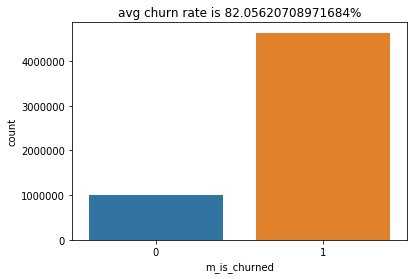

In [8]:
sns.countplot(x='m_is_churned', data=df2)
plt.title('avg churn rate is {}%'.format(100.0*df2.m_is_churned.sum()/len(df2.m_is_churned)))

Text(0.5,1,'avg churn rate is 92.16047651886599%')

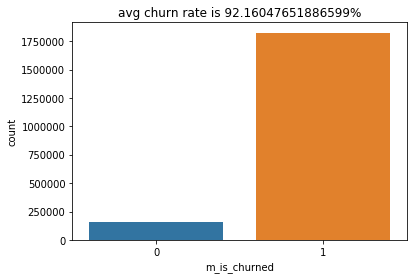

In [9]:
sns.countplot(x='m_is_churned', data=df2[df2.mix_ttd_avg.isnull()])
plt.title('avg churn rate is {}%'.format(100.0*df2[df2.mix_ttd_avg.isnull()].m_is_churned.sum()/len(df2[df2.mix_ttd_avg.isnull()].m_is_churned)))

Text(0.5,1,'avg churn rate is 76.5996020485252%')

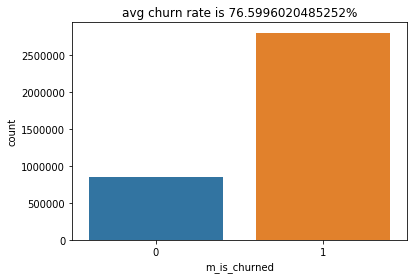

In [10]:
sns.countplot(x='m_is_churned', data=df2[df2.mix_ttd_avg.notnull()])
plt.title('avg churn rate is {}%'.format(100.0*df2[df2.mix_ttd_avg.notnull()].m_is_churned.sum()/len(df2[df2.mix_ttd_avg.notnull()].m_is_churned)))

In [11]:
def max_shown_bucket(x):
    if x<10:
        bucket = '10-'
    elif x<=20 :
        bucket = '10-20'
    elif x<=25 :
        bucket = '20-25'
    elif x<=30 :
        bucket = '25-30'
    elif x<=35 :
        bucket = '30-35'
    elif x<=40 :
        bucket = '35-40'
    elif x<=50 :
        bucket = '40-50'
    elif x>50 :
        bucket = '50+'
    return bucket

In [12]:
def we_bucket(x):
    if x<=0:
        bucket = '0-'
    elif x<=2 :
        bucket = '0-2'
    elif x<=5 :
        bucket = '2-5'
    elif x<=10 :
        bucket = '5-10'
    elif x<=20 :
        bucket = '10-20'
    elif x<=40 :
        bucket = '20-40'
    elif x<=90 :
        bucket = '40-90'
    elif x>90 :
        bucket = '90+'
    return bucket

In [13]:
df4 = df2.dropna(subset=['min_shipping_time_shown_avg', 'max_shipping_time_shown_avg'], inplace=False)
df4['we_bucket'] = df4['we_order_p'].apply(lambda x: we_bucket(x))
df4['max_shown_bucket'] = df4['max_shipping_time_shown_avg'].apply(lambda x: max_shown_bucket(x))
df4.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(5644372, 31)

In [14]:
df_group = df4[['we_bucket','max_shown_bucket','mix_ttd_avg']].groupby(['we_bucket','max_shown_bucket'],as_index=False)['mix_ttd_avg'].mean()
df_group.columns = ['we_bucket','max_shown_bucket','bucket_ttd_avg']
df5 = df4.merge(df_group,how='left',on=['we_bucket','max_shown_bucket'])
df5.head()

age  gender  waiting_day_1st_txn_bucket user_first_txn_refund_category  \
0  NaN       1                         0.0                      no refund   
1  NaN       2                         6.8                      no refund   
2  NaN       2                         0.0                      no refund   
3  NaN       2                         0.0                      no refund   
4  NaN       2                         0.0                      no refund   

   order_cnt  min_shipping_time_shown_avg  max_shipping_time_shown_avg  \
0          1                         17.0                         34.0   
1          1                         12.0                         29.0   
2          1                         13.0                         30.0   
3          1                         14.0                         29.0   
4          1                         20.0                         34.0   

   mix_ttd_avg   gmv  gmv_avg  ... gender_2  \
0          NaN   1.0     1.00  ...        0   
1         15.0  40.0    40.00  ...        1   
2          NaN   1.0     1.00  ...        1   
3          NaN   1.0     1.00  ...        1   
4         18.0  13.0    12.99  ...        1   

   user_first_txn_refund_category_logistics refund  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   user_first_txn_refund_category_no refund  \
0                                         1   
1                                         1   
2                                         1   
3                                         1   
4                                         1   

   user_first_txn_refund_category_other refund  user_ltv_segment_ltv_high  \
0                                            0                          0   
1                                            0                          0   
2                                            0                          0   
3                                            0                          0   
4                                            0                          0   

   user_ltv_segment_ltv_low  user_ltv_segment_ltv_med  we_bucket  \
0                         1                         0         0-   
1                         0                         1         0-   
2                         1                         0         0-   
3                         1                         0         0-   
4                         0                         1         0-   

   max_shown_bucket  bucket_ttd_avg  
0             30-35       17.537657  
1             25-30       17.197505  
2             25-30       17.197505  
3             25-30       17.197505  
4             30-35       17.537657  

[5 rows x 32 columns]

In [15]:
mask = df5.mix_ttd_avg.isnull()
df5.loc[mask,'mix_ttd_avg']=df5.loc[mask,'bucket_ttd_avg']

In [16]:
def ttd_bucket(x):
    if x<= 10:
        y = '10-'
    elif x<= 20:
        y = '10-20'
    elif x<= 30:
        y = '20-30'
    elif x<= 40:
        y = '30-40'
    elif x> 40:
        y = '40+'
    return y

df5['ttd_bucket'] = df5['mix_ttd_avg'].apply(lambda x: ttd_bucket(x))

In [17]:
a = df5
features = a.columns.values
b = list()
for f in features:
    b.append(100.0*sum(a[f].isnull())/a.shape[0])
df_missing = pd.DataFrame(b,index=features,columns=['missing_value_perc'])
df_missing

missing_value_perc
age                                                       95.956468
gender                                                     0.000000
waiting_day_1st_txn_bucket                                 0.000000
user_first_txn_refund_category                             0.000000
order_cnt                                                  0.000000
min_shipping_time_shown_avg                                0.000000
max_shipping_time_shown_avg                                0.000000
mix_ttd_avg                                                0.000000
gmv                                                        0.000000
gmv_avg                                                    0.000000
user_ltv_segment                                           0.000000
previous_m_is_churned                                      0.000000
late_days_avg                                              0.000000
late_order_p                                               0.000000
refund_order_p                                             0.000000
lr_order_p                                                 0.000000
we_order_p                                                 0.000000
m_is_churned                                               0.000000
user_first_txn_refund_cat                                  0.000000
user_ltv_segment_cat                                       0.000000
gender_0                                                   0.000000
gender_1                                                   0.000000
gender_2                                                   0.000000
user_first_txn_refund_category_logistics refund            0.000000
user_first_txn_refund_category_no refund                   0.000000
user_first_txn_refund_category_other refund                0.000000
user_ltv_segment_ltv_high                                  0.000000
user_ltv_segment_ltv_low                                   0.000000
user_ltv_segment_ltv_med                                   0.000000
we_bucket                                                  0.000000
max_shown_bucket                                           0.000000
bucket_ttd_avg                                             0.000000
ttd_bucket                                                 0.000000

In [18]:
df_encoding2 = pd.get_dummies(df5[['ttd_bucket']], prefix_sep='_',columns=['ttd_bucket'] , drop_first=False)
df_encoding2.head()

df6 = pd.concat([df5, df_encoding2], axis=1)
df6.head()

age  gender  waiting_day_1st_txn_bucket user_first_txn_refund_category  \
0  NaN       1                         0.0                      no refund   
1  NaN       2                         6.8                      no refund   
2  NaN       2                         0.0                      no refund   
3  NaN       2                         0.0                      no refund   
4  NaN       2                         0.0                      no refund   

   order_cnt  min_shipping_time_shown_avg  max_shipping_time_shown_avg  \
0          1                         17.0                         34.0   
1          1                         12.0                         29.0   
2          1                         13.0                         30.0   
3          1                         14.0                         29.0   
4          1                         20.0                         34.0   

   mix_ttd_avg   gmv  gmv_avg  ... user_ltv_segment_ltv_med  we_bucket  \
0    17.537657   1.0     1.00  ...                        0         0-   
1    15.000000  40.0    40.00  ...                        1         0-   
2    17.197505   1.0     1.00  ...                        0         0-   
3    17.197505   1.0     1.00  ...                        0         0-   
4    18.000000  13.0    12.99  ...                        1         0-   

   max_shown_bucket  bucket_ttd_avg  ttd_bucket  ttd_bucket_10-  \
0             30-35       17.537657       10-20               0   
1             25-30       17.197505       10-20               0   
2             25-30       17.197505       10-20               0   
3             25-30       17.197505       10-20               0   
4             30-35       17.537657       10-20               0   

   ttd_bucket_10-20  ttd_bucket_20-30  ttd_bucket_30-40  ttd_bucket_40+  
0                 1                 0                 0               0  
1                 1                 0                 0               0  
2                 1                 0                 0               0  
3                 1                 0                 0               0  
4                 1                 0                 0               0  

[5 rows x 38 columns]

In [19]:
df6.columns

Index(['age', 'gender', 'waiting_day_1st_txn_bucket',
       'user_first_txn_refund_category', 'order_cnt',
       'min_shipping_time_shown_avg', 'max_shipping_time_shown_avg',
       'mix_ttd_avg', 'gmv', 'gmv_avg', 'user_ltv_segment',
       'previous_m_is_churned', 'late_days_avg', 'late_order_p',
       'refund_order_p', 'lr_order_p', 'we_order_p', 'm_is_churned',
       'user_first_txn_refund_cat', 'user_ltv_segment_cat', 'gender_0',
       'gender_1', 'gender_2',
       'user_first_txn_refund_category_logistics refund',
       'user_first_txn_refund_category_no refund',
       'user_first_txn_refund_category_other refund',
       'user_ltv_segment_ltv_high', 'user_ltv_segment_ltv_low',
       'user_ltv_segment_ltv_med', 'we_bucket', 'max_shown_bucket',
       'bucket_ttd_avg', 'ttd_bucket', 'ttd_bucket_10-', 'ttd_bucket_10-20',
       'ttd_bucket_20-30', 'ttd_bucket_30-40', 'ttd_bucket_40+'],
      dtype='object')

In [86]:
mask1 = df6.mix_ttd_avg >= 8
mask2 = df6.mix_ttd_avg <= 28

X= df6[mask1 & mask2].drop(['m_is_churned','gender','age','min_shipping_time_shown_avg','user_first_txn_refund_category','user_ltv_segment','user_first_txn_refund_cat'
                            ,'user_ltv_segment_cat','gmv','we_bucket','max_shown_bucket','bucket_ttd_avg','ttd_bucket','ttd_bucket_10-','ttd_bucket_10-20'
                            ,'ttd_bucket_20-30','ttd_bucket_30-40','ttd_bucket_40+'],axis=1)

y= df6[mask1 & mask2].m_is_churned

scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
print('The average TTD from 8 to 28 days, covers {}% total orders'.format(round(100*sum((df6.mix_ttd_avg<=28) & (df6.mix_ttd_avg>=8))/len(df6.mix_ttd_avg),1)))

The average TTD from 8 to 28 days, covers 89.2% total orders


In [84]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,random_state=66,test_size=0.3, stratify=y)
x_train.shape,x_test.shape

((3523892, 20), (1510240, 20))

In [85]:
# log_reg = LogisticRegression()
# log_reg.fit(x_train, y_train)
# round(100*log_reg.score(x_test,y_test),1)

In [87]:
log_reg_l1 = LogisticRegression(C=0.01, penalty='l1',solver='liblinear')
log_reg_l1.fit(x_train, y_train)


y_pred_l1 = log_reg_l1.predict(x_test)
y_pred_prob_l1 = log_reg_l1.predict_proba(x_test)
# y_pred_l1, y_pred_prob_l1
round(100*log_reg_l1.score(x_test,y_test),1)

85.7

In [88]:
print(classification_report(y_test,y_pred_l1))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54    277412
           1       0.89      0.95      0.92   1232828

    accuracy                           0.86   1510240
   macro avg       0.77      0.70      0.73   1510240
weighted avg       0.84      0.86      0.85   1510240



In [89]:
confusion_matrix(y_test,y_pred_l1)

array([[ 128222,  149190],
       [  66350, 1166478]])

In [90]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_l1).ravel()
tn, fp, fn, tp
# fn=100233 is most important for us
# fn means there are 12079 users actually churned, but the model predicts as not churned.

# 所有真的y=1(churn)中，预测churn对了92.5%
recall=tp/(tp+fn)
print('recall is {}%'.format(round(100*recall,1)))

#所有预测为y=1(churn)中，有86.6%真的churn了
precision = tp/(tp+fp)
print('precision is {}%'.format(round(100*precision,1)))
# round(100*precision,1)

# overall accuracy, equal to above score() = 83%
accuracy= (tp+tn)/(tp+tn+fn+fp)
print('accuracy is {}%'.format(round(100*accuracy,1)))
# round(100*accuracy,1)

recall is 94.6%
precision is 88.7%
accuracy is 85.7%


In [91]:
importance = log_reg_l1.coef_[0]
name = x_train.columns
feature_importance = pd.DataFrame(importance,index=name,columns=['importance'])
feature_importance.sort_values(by='importance')

importance
order_cnt                                         -0.316407
user_ltv_segment_ltv_high                         -0.220027
lr_order_p                                        -0.089189
waiting_day_1st_txn_bucket                        -0.067255
late_days_avg                                     -0.056923
gender_1                                          -0.053457
user_first_txn_refund_category_logistics refund   -0.025598
we_order_p                                        -0.016096
gender_2                                           0.000000
user_first_txn_refund_category_other refund        0.000000
user_ltv_segment_ltv_med                           0.000000
mix_ttd_avg                                        0.000394
user_first_txn_refund_category_no refund           0.016624
late_order_p                                       0.022191
gender_0                                           0.047120
max_shipping_time_shown_avg                        0.070149
refund_order_p                                     0.162591
gmv_avg                                            0.292452
user_ltv_segment_ltv_low                           0.294616
previous_m_is_churned                              0.711722

<BarContainer object of 20 artists>

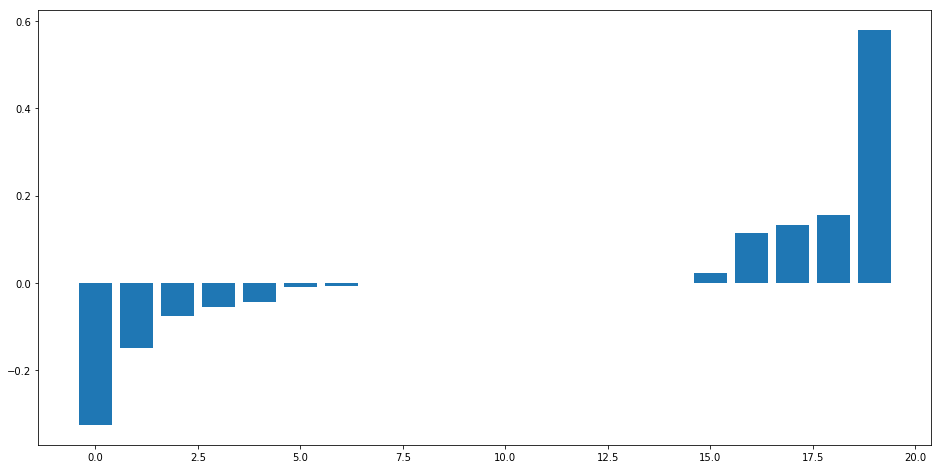

In [89]:
plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance))], feature_importance.sort_values(by='importance').importance)

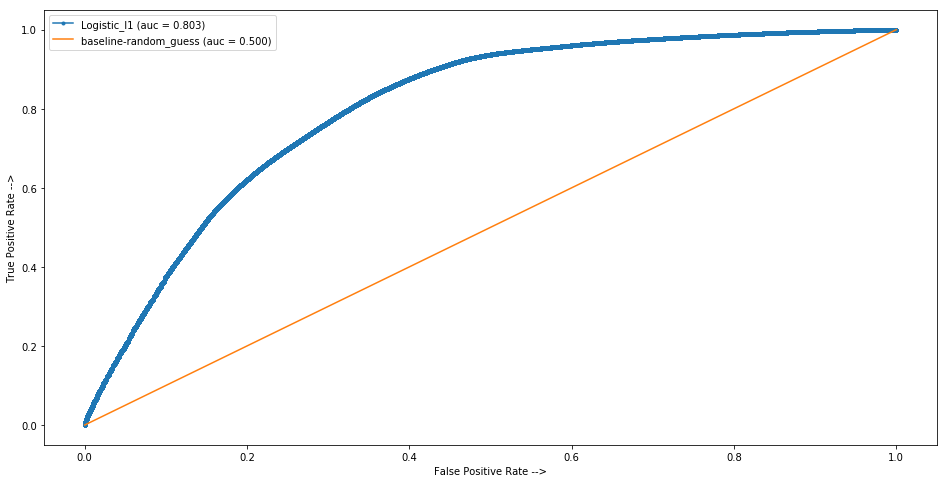

In [205]:
y_score_log_l1 = log_reg_l1.decision_function(x_test)
base_probs = [0 for _ in range(len(y_test))]
# len(base_probs), len(y_score_log_l1)

logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_prob_l1[:,1])
auc_logistic = auc(logistic_fpr, logistic_tpr)

base_fpr, base_tpr, base_threshold = roc_curve(y_test, base_probs)
auc_base = auc(base_fpr, base_tpr)

plt.figure(figsize=(16, 8))
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.3f)' % auc_logistic)
plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()

plt.show()

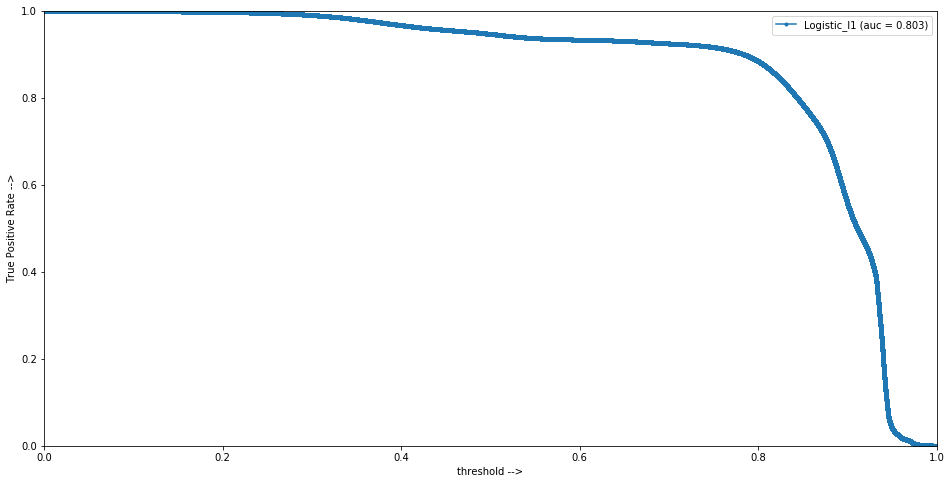

In [206]:
plt.figure(figsize=(16, 8))
plt.plot(threshold, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.3f)' % auc_logistic)
# plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('threshold -->')
plt.ylabel('True Positive Rate -->')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

plt.show()

Text(0.5,1,'distribution of users profile - mix_ttd_avg')

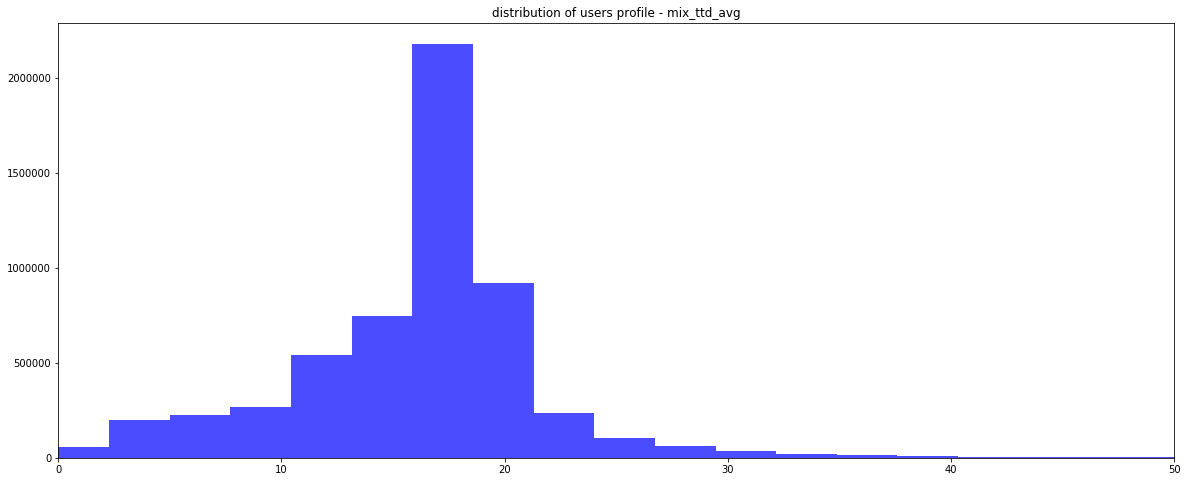

In [61]:
plt.figure(figsize=(20,8))
plt.xlim(0,50)
plt.hist(x=df6.mix_ttd_avg.dropna(axis='index'), bins=300, color='blue', alpha=0.7)
plt.title('distribution of users profile - mix_ttd_avg')

The average TTD from 8 to 28 days, covers 89.2% total orders


### max_shipping_time_shown_avg & we_order_p -55%
### late_days_avg(removed) & late_order_p 52% 
### refund_order_p(removed) & lr_order_p 53% 
### user_first_txn_refund_category & refund_order_p(removed) -74% & 64% 
### lr_order_p & user_first_txn_refund_category_logistics(removed) 69% 


In [171]:
df_new.corr()

waiting_day_1st_txn_bucket  \
waiting_day_1st_txn_bucket                                     1.000000   
order_cnt                                                      0.006280   
max_shipping_time_shown_avg                                   -0.060707   
gmv_avg                                                        0.030838   
previous_m_is_churned                                         -0.019919   
late_order_p                                                   0.023207   
gender_0                                                      -0.021851   
gender_1                                                      -0.025091   
user_first_txn_refund_category_other refund                    0.020296   
user_ltv_segment_ltv_high                                      0.042095   
user_ltv_segment_ltv_low                                      -0.102438   
ttd_bucket_10-                                                 0.016080   
ttd_bucket_20-30                                               0.026168   
ttd_bucket_30-40                                               0.004036   
ttd_bucket_40+                                                 0.002612   

                                             order_cnt  \
waiting_day_1st_txn_bucket                    0.006280   
order_cnt                                     1.000000   
max_shipping_time_shown_avg                   0.011483   
gmv_avg                                      -0.033233   
previous_m_is_churned                        -0.314150   
late_order_p                                  0.016130   
gender_0                                     -0.018159   
gender_1                                     -0.056043   
user_first_txn_refund_category_other refund   0.026954   
user_ltv_segment_ltv_high                     0.338921   
user_ltv_segment_ltv_low                     -0.220209   
ttd_bucket_10-                               -0.065420   
ttd_bucket_20-30                              0.094794   
ttd_bucket_30-40                             -0.000216   
ttd_bucket_40+                               -0.005006   

                                             max_shipping_time_shown_avg  \
waiting_day_1st_txn_bucket                                     -0.060707   
order_cnt                                                       0.011483   
max_shipping_time_shown_avg                                     1.000000   
gmv_avg                                                        -0.253094   
previous_m_is_churned                                           0.046120   
late_order_p                                                   -0.185491   
gender_0                                                       -0.010959   
gender_1                                                       -0.061328   
user_first_txn_refund_category_other refund                    -0.044703   
user_ltv_segment_ltv_high                                      -0.124694   
user_ltv_segment_ltv_low                                        0.192059   
ttd_bucket_10-                                                 -0.385347   
ttd_bucket_20-30                                                0.092064   
ttd_bucket_30-40                                                0.056125   
ttd_bucket_40+                                                  0.053068   

                                              gmv_avg  previous_m_is_churned  \
waiting_day_1st_txn_bucket                   0.030838              -0.019919   
order_cnt                                   -0.033233              -0.314150   
max_shipping_time_shown_avg                 -0.253094               0.046120   
gmv_avg                                      1.000000               0.025523   
previous_m_is_churned                        0.025523               1.000000   
late_order_p                                 0.063723              -0.007717   
gender_0                                     0.030956               0.031043   
gender_1                                     0.092168     

In [193]:
df_ori = df6.drop(['m_is_churned','gender','age','min_shipping_time_shown_avg','user_first_txn_refund_category','user_ltv_segment','user_first_txn_refund_cat','user_ltv_segment_cat','gmv',
             'we_bucket','max_shown_bucket','bucket_ttd_avg','ttd_bucket','mix_ttd_avg'],axis=1)
new_drop_feature = ['we_order_p','user_first_txn_refund_category_logistics refund','late_days_avg','refund_order_p','user_ltv_segment_ltv_med','gender_2',
                    'user_first_txn_refund_category_no refund']

df_new = df_ori.drop(new_drop_feature,axis=1)

y= df6.m_is_churned

scaler = StandardScaler()
scaler.fit(df_new) 
X_scaled = pd.DataFrame(scaler.transform(df_new),columns = df_new.columns)

x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,random_state=66,test_size=0.3, stratify=y)
x_train.shape,x_test.shape

log_reg_l1 = LogisticRegression(C=0.001, penalty='l1')
log_reg_l1.fit(x_train, y_train)
round(100*log_reg_l1.score(x_test,y_test),1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


82.9

In [194]:
y_pred_l1 = log_reg_l1.predict(x_test)
y_pred_prob_l1 = log_reg_l1.predict_proba(x_test)
y_pred_l1, y_pred_prob_l1

print(classification_report(y_test,y_pred_l1))

print(confusion_matrix(y_test,y_pred_l1))

              precision    recall  f1-score   support

           0       0.64      0.49      0.55    370747
           1       0.87      0.92      0.89   1340540

    accuracy                           0.83   1711287
   macro avg       0.75      0.70      0.72   1711287
weighted avg       0.82      0.83      0.82   1711287

[[ 180204  190543]
 [ 102500 1238040]]


In [195]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_l1).ravel()
tn, fp, fn, tp

recall=tp/(tp+fn)
print(round(100*recall,1))

precision = tp/(tp+fp)
print(round(100*precision,1))

accuracy= (tp+tn)/(tp+tn+fn+fp)
print(round(100*accuracy,1))

importance = log_reg_l1.coef_[0]
name = x_train.columns
feature_importance = pd.DataFrame(importance,index=name,columns=['importance'])
feature_importance.sort_values(by='importance')

92.4
86.7
82.9


importance
order_cnt                                     -0.369223
user_ltv_segment_ltv_high                     -0.164569
waiting_day_1st_txn_bucket                    -0.077844
ttd_bucket_40+                                -0.062573
gender_1                                      -0.040731
ttd_bucket_20-30                              -0.035976
ttd_bucket_30-40                              -0.033111
lr_order_p                                    -0.000686
ttd_bucket_10-20                               0.000000
late_order_p                                   0.021786
ttd_bucket_10-                                 0.041152
max_shipping_time_shown_avg                    0.048617
gender_0                                       0.048830
user_first_txn_refund_category_other refund    0.062932
user_ltv_segment_ltv_low                       0.214818
gmv_avg                                        0.250266
previous_m_is_churned                          0.736423

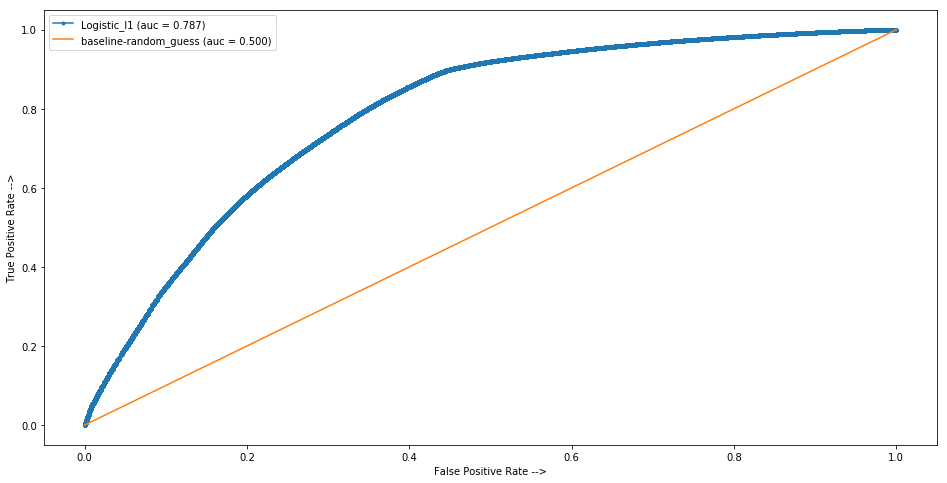

In [196]:
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_prob_l1[:,1])
auc_logistic = auc(logistic_fpr, logistic_tpr)
# y_pred_prob_l1

base_fpr, base_tpr, base_threshold = roc_curve(y_test, base_probs)
auc_base = auc(base_fpr, base_tpr)

plt.figure(figsize=(16, 8))
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.3f)' % auc_logistic)
plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()

plt.show()

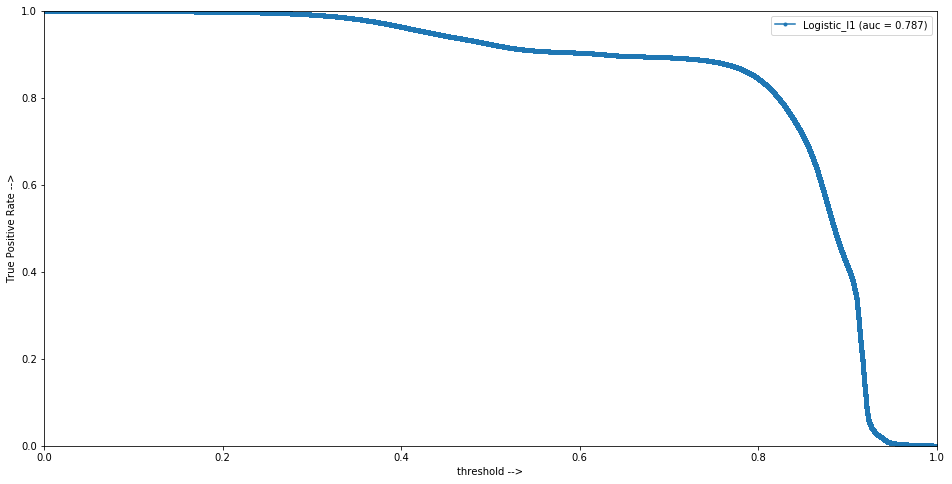

In [197]:
plt.figure(figsize=(16, 8))
plt.plot(threshold, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.3f)' % auc_logistic)
# plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('threshold -->')
plt.ylabel('True Positive Rate -->')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

plt.show()